In [140]:
import pandas as pd
import geopandas as gpd
import h5py
import matplotlib.pyplot as plt
import re

In [ ]:
climate_file_path = "../Calabria_dataset/InputReteGood/Climatic/2017/20170701.h5"

df_cell_zones = pd.read_parquet("cell_zones.parquet")
gdf_zones = gpd.read_file("Processed_Zones/cell_zones/cell_zones.shp")

In [142]:
# Inspect file structure
with h5py.File(climate_file_path, "r") as h5_file:
    print("Top-level keys:", list(h5_file.keys()))
    
    for key in h5_file.keys():
        print(f"'{key}' contains:", list(h5_file[key].keys()))

Top-level keys: ['attributes', 'values']
'attributes' contains: ['_i_table', 'table']
'values' contains: ['_i_table', 'table']


In [143]:
# Extract attributes
with h5py.File(climate_file_path, "r") as h5_file:
    attributes_table = h5_file["attributes/table"][:]

attribute_names = [attr[0].decode() for attr in attributes_table]
attribute_values = [attr[1][0] for attr in attributes_table]

attributes_dict = dict(zip(attribute_names, attribute_values))
attributes_dict

{'ncols': np.float32(1490.0),
 'nrows': np.float32(2592.0),
 'xllcorner': np.float32(549915.4),
 'yllcorner': np.float32(4189379.2),
 'cellsize': np.float32(100.0),
 'NODATA_value': np.float32(nan)}

In [144]:
# Extract ncols and nrows
ncols = int(attributes_dict["ncols"]) if "ncols" in attributes_dict else None
nrows = int(attributes_dict["nrows"]) if "nrows" in attributes_dict else None

print(f"Number of columns: {ncols}")
print(f"Number of rows: {nrows}")
print(f"Grid size: {ncols} cols × {nrows} rows")

Number of columns: 1490
Number of rows: 2592
Grid size: 1490 cols × 2592 rows


In [145]:
# Load values and variable names
with h5py.File(climate_file_path, "r") as h5_file:
    values_table = h5_file["values/table"]
    climate_names_raw = values_table.attrs["values_block_0_kind"].decode()
    climate_names = re.findall(r'V([A-Za-z0-9_]+)', climate_names_raw)
    table_data = values_table[:]

index_values = table_data["index"]
climate_values = table_data["values_block_0"]
climate_names

['Pprecmap', 'RHmap', 'Tmap', 'Vmap']

In [146]:
# Convert index into row and column coordinates
row_coords = index_values // ncols  
col_coords = index_values % ncols  
row_coords, col_coords

(array([   0,    0,    0, ..., 2591, 2591, 2591], shape=(3862080,)),
 array([   0,    1,    2, ..., 1487, 1488, 1489], shape=(3862080,)))

In [147]:
# Build climate DataFrame with corrected spatial coordinates
df_climate = pd.DataFrame({
    "Row": row_coords,
    "Column": col_coords,
    "Precipitation": climate_values[:, 0],
    "Humidity": climate_values[:, 1],
    "Temperature": climate_values[:, 2],
    "Wind": climate_values[:, 3],
    "X_Coord": attributes_dict["xllcorner"] + (col_coords * attributes_dict["cellsize"]),
    "Y_Coord": attributes_dict["yllcorner"] + ((nrows - 1 - row_coords) * attributes_dict["cellsize"])
})


In [148]:
df_climate

,Row,Column,Precipitation,Humidity,Temperature,Wind,X_Coord,Y_Coord
0,0,0,NaN,NaN,NaN,NaN,549915.375,4448479.25
1,0,1,NaN,NaN,NaN,NaN,550015.375,4448479.25
2,0,2,NaN,NaN,NaN,NaN,550115.375,4448479.25
3,0,3,NaN,NaN,NaN,NaN,550215.375,4448479.25
4,0,4,NaN,NaN,NaN,NaN,550315.375,4448479.25
...,...,...,...,...,...,...,...,...
3862075,2591,1485,NaN,NaN,NaN,NaN,698415.375,4189379.25
3862076,2591,1486,NaN,NaN,NaN,NaN,698515.375,4189379.25
3862077,2591,1487,NaN,NaN,NaN,NaN,698615.375,4189379.25
3862078,2591,1488,NaN,NaN,NaN,NaN,698715.375,4189379.25


In [149]:
# Adjust climate Y coordinates
df_climate["Y_Coord"] = df_climate["Y_Coord"].round(-0).astype(float).round(1)

df_climate

,Row,Column,Precipitation,Humidity,Temperature,Wind,X_Coord,Y_Coord
0,0,0,NaN,NaN,NaN,NaN,549915.375,4448479.0
1,0,1,NaN,NaN,NaN,NaN,550015.375,4448479.0
2,0,2,NaN,NaN,NaN,NaN,550115.375,4448479.0
3,0,3,NaN,NaN,NaN,NaN,550215.375,4448479.0
4,0,4,NaN,NaN,NaN,NaN,550315.375,4448479.0
...,...,...,...,...,...,...,...,...
3862075,2591,1485,NaN,NaN,NaN,NaN,698415.375,4189379.0
3862076,2591,1486,NaN,NaN,NaN,NaN,698515.375,4189379.0
3862077,2591,1487,NaN,NaN,NaN,NaN,698615.375,4189379.0
3862078,2591,1488,NaN,NaN,NaN,NaN,698715.375,4189379.0


In [ ]:
df_climate.loc[(df_climate["X_Coord"] == 621115.375) & (df_climate["Y_Coord"] == 4444379.0)]

,Row,Column,Precipitation,Humidity,Temperature,Wind,X_Coord,Y_Coord
61802,41,712,0.0,34.937561,30.150095,10.675401,621115.375,4444379.0


In [153]:
df_cell_zones

,Row,Column,X_Coord,Y_Coord,geometry,Zone_ID
0,74,179,567815.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\x0eT!A\...,8.0
1,74,180,567915.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xd6T!A\...,8.0
2,74,181,568015.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\x9eU!A\...,8.0
3,74,182,568115.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0fV!A\x00...,8.0
4,74,183,568215.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0.W!A\x00...,8.0
...,...,...,...,...,...,...
1507648,2550,712,621115.375,4444379.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0v\xf4""A\...",5.0
1507649,2550,713,621215.375,4444379.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0>\xf5""A\...",5.0
1507650,2551,711,621015.375,4444479.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xae\xf3...,5.0
1507651,2551,712,621115.375,4444479.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0v\xf4""A\...",5.0


In [158]:
# Merge climate data onto zone-mapped cells
df_climate = df_cell_zones[["X_Coord", "Y_Coord", "Zone_ID"]].merge(
    df_climate,
    on=["X_Coord", "Y_Coord"],
    how="left"
)
df_climate

,X_Coord,Y_Coord,Zone_ID,Row,Column,Precipitation,Humidity,Temperature,Wind
0,567815.375,4196779.0,8.0,2517,179,0.0,43.453739,30.943409,19.785675
1,567915.375,4196779.0,8.0,2517,180,0.0,43.457977,30.943258,19.795025
2,568015.375,4196779.0,8.0,2517,181,0.0,43.463036,30.942766,19.804356
3,568115.375,4196779.0,8.0,2517,182,0.0,43.464634,30.943758,19.813671
4,568215.375,4196779.0,8.0,2517,183,0.0,43.467197,30.945190,19.827629
...,...,...,...,...,...,...,...,...,...
1507648,621115.375,4444379.0,5.0,41,712,0.0,34.937561,30.150095,10.675401
1507649,621215.375,4444379.0,5.0,41,713,0.0,34.943012,30.143555,10.676477
1507650,621015.375,4444479.0,5.0,40,711,0.0,34.956539,30.157795,10.669076
1507651,621115.375,4444479.0,5.0,40,712,0.0,34.956444,30.153513,10.670221


In [159]:
# Convert to GeoDataFrame
gdf_climate_zones = gpd.GeoDataFrame(
    df_climate,
    geometry=gpd.points_from_xy(df_climate["X_Coord"], df_climate["Y_Coord"]),
    crs="EPSG:32633"
)

gdf_climate_zones

,X_Coord,Y_Coord,Zone_ID,Row,Column,Precipitation,Humidity,Temperature,Wind,geometry
0,567815.375,4196779.0,8.0,2517,179,0.0,43.453739,30.943409,19.785675,POINT (567815.375 4196779)
1,567915.375,4196779.0,8.0,2517,180,0.0,43.457977,30.943258,19.795025,POINT (567915.375 4196779)
2,568015.375,4196779.0,8.0,2517,181,0.0,43.463036,30.942766,19.804356,POINT (568015.375 4196779)
3,568115.375,4196779.0,8.0,2517,182,0.0,43.464634,30.943758,19.813671,POINT (568115.375 4196779)
4,568215.375,4196779.0,8.0,2517,183,0.0,43.467197,30.945190,19.827629,POINT (568215.375 4196779)
...,...,...,...,...,...,...,...,...,...,...
1507648,621115.375,4444379.0,5.0,41,712,0.0,34.937561,30.150095,10.675401,POINT (621115.375 4444379)
1507649,621215.375,4444379.0,5.0,41,713,0.0,34.943012,30.143555,10.676477,POINT (621215.375 4444379)
1507650,621015.375,4444479.0,5.0,40,711,0.0,34.956539,30.157795,10.669076,POINT (621015.375 4444479)
1507651,621115.375,4444479.0,5.0,40,712,0.0,34.956444,30.153513,10.670221,POINT (621115.375 4444479)


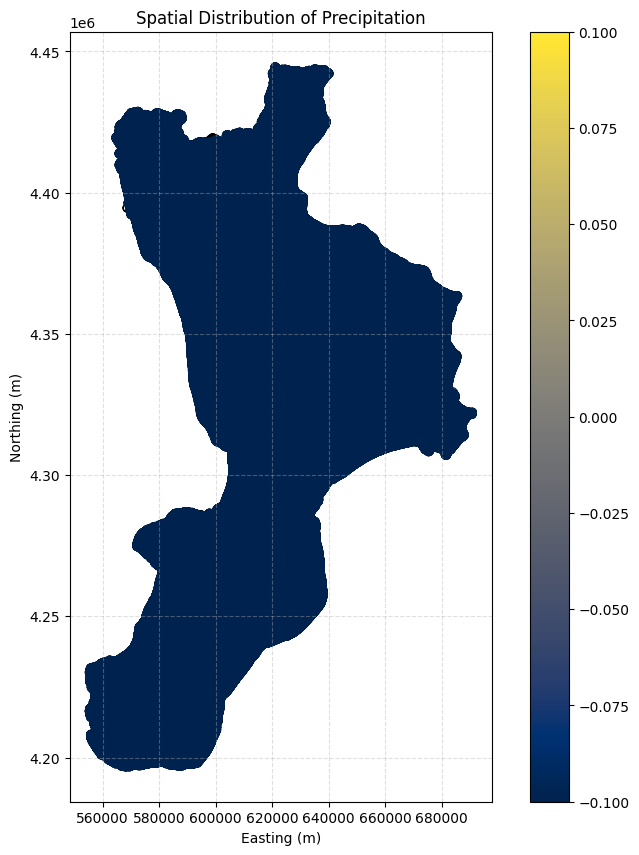

In [160]:
# Plot precipitation map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_zones.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
gdf_climate_zones.plot(column="Precipitation", cmap="cividis", legend=True, ax=ax, markersize=30)

plt.title("Spatial Distribution of Precipitation")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

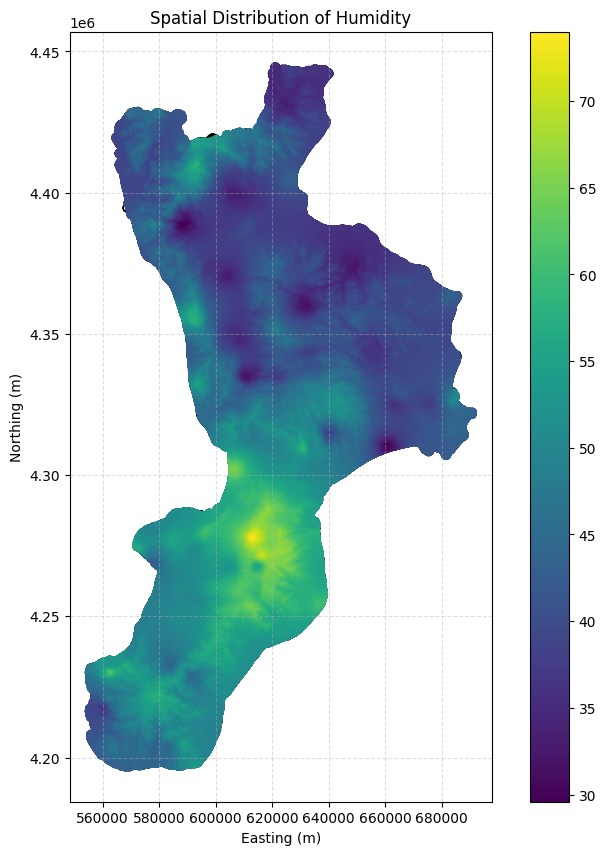

In [161]:
# Plot humidity map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_zones.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
gdf_climate_zones.plot(column="Humidity", cmap="viridis", legend=True, ax=ax, markersize=30)

plt.title("Spatial Distribution of Humidity")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

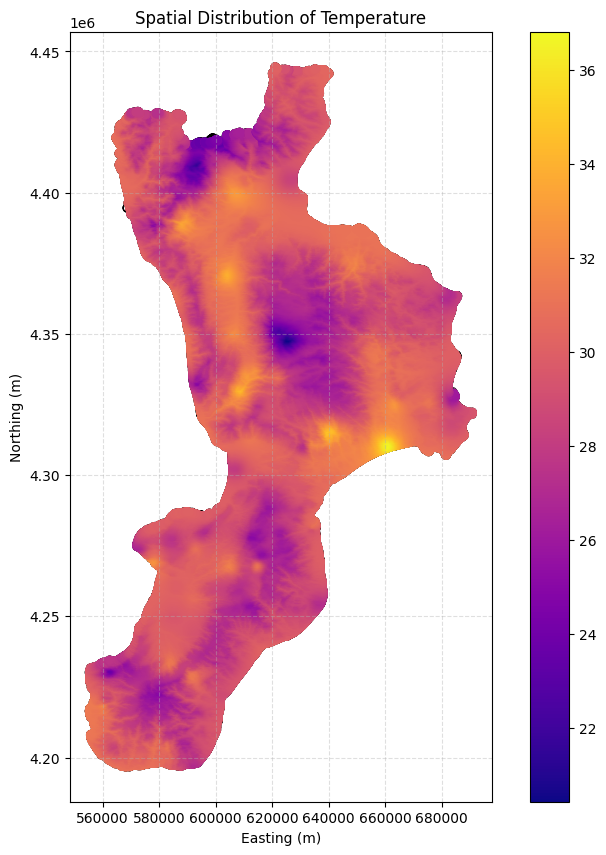

In [162]:
# Plot temperature map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_zones.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
gdf_climate_zones.plot(column="Temperature", cmap="plasma", legend=True, ax=ax, markersize=30)

plt.title("Spatial Distribution of Temperature")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


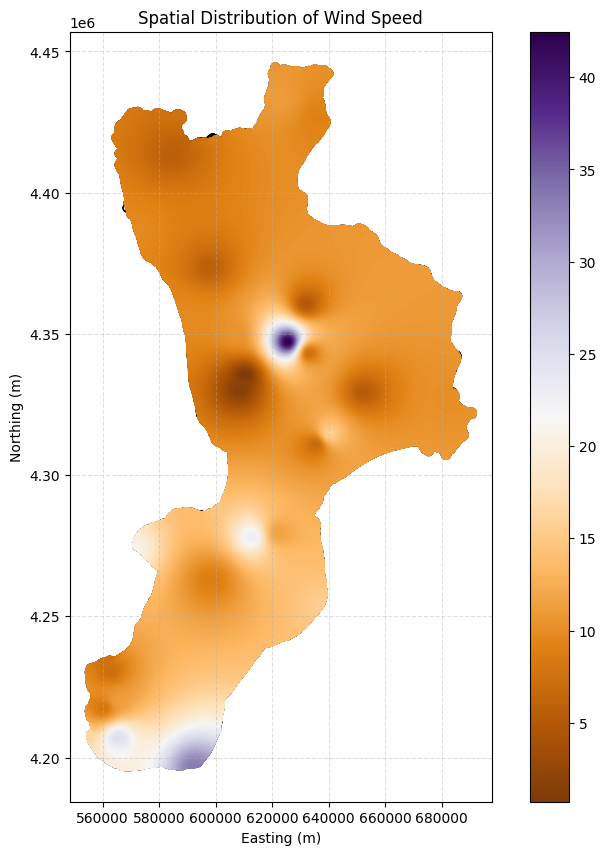

In [163]:
# Plot wind speed map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_zones.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
gdf_climate_zones.plot(column="Wind", cmap="PuOr", legend=True, ax=ax, markersize=30)

plt.title("Spatial Distribution of Wind Speed")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()